In [2]:
import uqer
import pandas as pd
import numpy as np
import datetime as dt
import holidays
from uqer import DataAPI
client = uqer.Client(token='3258db0b3d9f68e5f490948c8fe0b85f95dace2667c3a1d533d96100f5ab878d')

d77a82643u@jin.com 账号登录成功


In [3]:
#月度，持仓比加权
today=pd.Timestamp('today').strftime('%Y%m%d')
t=DataAPI.TradeCalGet(exchangeCD=u"XHKG",beginDate=u"20220101",endDate=today,isOpen=u"1",field=u"",pandas="1")

adjusted_dates=[]
t1=t.loc[t['isMonthEnd']==1]
last_valid_date = None

for date_str in t1['calendarDate']:
    if last_valid_date is None:
        date = pd.Timestamp(date_str)
    else:
        date = last_valid_date

    c = DataAPI.HKSHSZHoldChgGet(secID=u"",ticker=u"",tradeDate=date,valueType=u"1",beginDate=u"",endDate=u"",exchangeCD=u"",field=u"secID,value,tradeCD,tradeDate",pandas="1")
    c1 = c.loc[c['tradeCD'] == '3']

    
        
    while c1.empty:
        date -= pd.Timedelta(days=1)
        c = DataAPI.HKSHSZHoldChgGet(secID=u"",ticker=u"",tradeDate=date,valueType=u"1",beginDate=u"",endDate=u"",exchangeCD=u"",field=u"secID,value,tradeCD,tradeDate",pandas="1")
        c1 = c.loc[c['tradeCD'] == '3']
    
    
    adjusted_dates.append(date.strftime('%Y%m%d'))


In [4]:
weighted_yield = []

for date in adjusted_dates:
    a = DataAPI.HKSHSZHoldChgGet(
        secID=u"",
        ticker=u"",
        tradeDate=date,
        valueType=u"1",
        beginDate=u"",
        endDate=u"",
        exchangeCD=u"",
        field=u"secID,value,tradeCD,tradeDate",
        pandas="1"
    )
    daily_data = a.loc[a['tradeCD'] == '3']
    top_50 = daily_data.sort_values(by='value', ascending=False).head(50)
    
    daily_yeild = 0  # 重置daily_yeild为0
    
    for stock in top_50.itertuples(index=False):
        s = DataAPI.MktHKEqudGet(
            secID=stock.secID,
            ticker=u"",
            tradeDate=date,
            beginDate=u"",
            endDate=u"",
            field=u"",
            pandas="1"
        )
        
        # 确保's' DataFrame不是空的，以避免潜在的KeyError
        if not s.empty:
            value_1 = (s['chg'] / s['preClosePrice']) * stock.value / 100
            daily_yeild += value_1
    
    # 添加每天的加权收益率到列表中
    weighted_yield.append({'date': date, 'weighted_yield': float(daily_yeild)})

In [5]:
#对比恒生指数
hsi_result=[]
for date in adjusted_dates:
    hsi=DataAPI.MktIdxdGet(indexID=u"",ticker=u"HSI",tradeDate=date,beginDate=u"",endDate=u"",exchangeCD=u"",field=u"",pandas="1")
    hsi_yield=hsi['CHG']/hsi['preCloseIndex']
    hsi_result.append({'date':date, 'yield':float(hsi_yield)})

c:\Users\Liu Ailing\anaconda3\envs\name\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


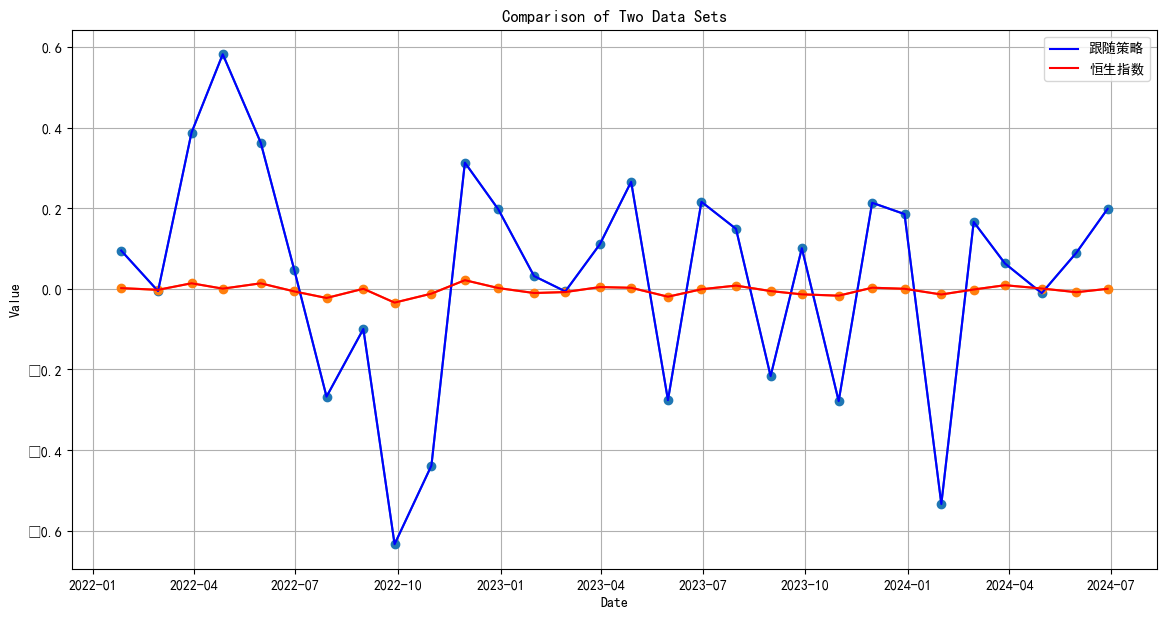

In [6]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'SimHei'

df1=pd.DataFrame(weighted_yield)
df2=pd.DataFrame(hsi_result)

df1['date'] = pd.to_datetime(df1['date'])
df2['date'] = pd.to_datetime(df2['date'])

df1.set_index('date', inplace=True)
df2.set_index('date', inplace=True)

plt.figure(figsize=(14, 7))
plt.plot(df1.index, df1['weighted_yield'], marker='o')
plt.plot(df2.index, df2['yield'], marker='o')

plt.plot(df1.index, df1['weighted_yield'], label='跟随策略', color='blue')

plt.plot(df2.index, df2['yield'], label='恒生指数', color='red')

plt.legend()
plt.title('Comparison of Two Data Sets')
plt.xlabel('Date')
plt.ylabel('Value')

plt.grid(True)
plt.show()
